# Notebook Over View, EDA2_PreProcessing


* In this note book we will continue EDA, this will focus on bivariant analysis in respect to our response/target variable (Fully paid and Charge off)


* The post analysis will then be followed by pre- processing in preparation for modeling. 


* SKLean Modeling, 


* PyCaret Modeling, depending on computing processing power.


* SWOT Analysis (Post Modeling Analysis)


* Recommendations/Next Steps

# Loading Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 200, 'display.max_columns', 200)

%config Completer.use_jedi = False

## Asset Loading

In [2]:
# Creating a pandas dataframe to work with. 
# Also, including low_memory option to mitigate the taxing computational resources

Working_DF = pd.read_csv('clean_accepted_3.csv', low_memory=True)

In [3]:
# Sanity checking the Working_DF

Working_DF.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,application_type,tot_cur_bal,mort_acc,pub_rec_bankruptcies,annual_inc_log,fico_score
0,25000.0,36 months,17.99,903.69,D,D2,1,MORTGAGE,67500.0,Source Verified,Mar-2017,Charged Off,debt_consolidation,TX,19.41,1995,25.0,0.0,43658.0,56.3,f,Individual,173292.0,2.0,0.0,11.119883,662.0
1,10000.0,36 months,11.53,329.91,B,B5,3,RENT,45000.0,Not Verified,Jun-2015,Fully Paid,debt_consolidation,WA,29.23,2003,20.0,0.0,7459.0,58.3,f,Individual,62916.0,0.0,0.0,10.714418,682.0
2,6950.0,36 months,15.88,243.93,C,C4,3,RENT,41810.0,Verified,Sep-2013,Fully Paid,debt_consolidation,WA,17.25,1988,6.0,1.0,10723.0,58.0,f,Individual,197096.0,2.0,1.0,10.640891,667.0
3,24000.0,60 months,12.69,542.28,C,C2,3,MORTGAGE,100000.0,Not Verified,Sep-2015,Fully Paid,debt_consolidation,AZ,22.22,1996,9.0,0.0,22654.0,89.2,w,Individual,281268.0,2.0,0.0,11.512925,697.0
4,15000.0,60 months,24.99,440.19,F,F4,10,MORTGAGE,65000.0,Verified,Jan-2014,Fully Paid,debt_consolidation,MA,25.24,2003,16.0,0.0,9269.0,25.3,f,Individual,253377.0,2.0,0.0,11.082143,667.0


In [4]:
# Checking info and dtypes

Working_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246269 entries, 0 to 246268
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             246269 non-null  float64
 1   term                  246269 non-null  object 
 2   int_rate              246269 non-null  float64
 3   installment           246269 non-null  float64
 4   grade                 246269 non-null  object 
 5   sub_grade             246269 non-null  object 
 6   emp_length            246269 non-null  int64  
 7   home_ownership        246269 non-null  object 
 8   annual_inc            246269 non-null  float64
 9   verification_status   246269 non-null  object 
 10  issue_d               246269 non-null  object 
 11  loan_status           246269 non-null  object 
 12  purpose               246269 non-null  object 
 13  addr_state            246269 non-null  object 
 14  dti                   246269 non-null  float64
 15  

The data look good from our last notebook, so we will move on to exploring the response/target variable.

# Response/Target Variable 

This section we will explore our response variable, Fully-Paid and Charge-off. 

Note, fully-paid means that the borrower(s) have fulfilled their loan obligation by pay the investor back. As charge-off means, that the borrower has either defaulted on the loan and has decided to settle/negotiate a settlement for the remaining balance of the loan.

In [5]:
# checking the value count of our target

Working_DF['loan_status'].value_counts()

Fully Paid     197386
Charged Off     48883
Name: loan_status, dtype: int64

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Demographic of Target')

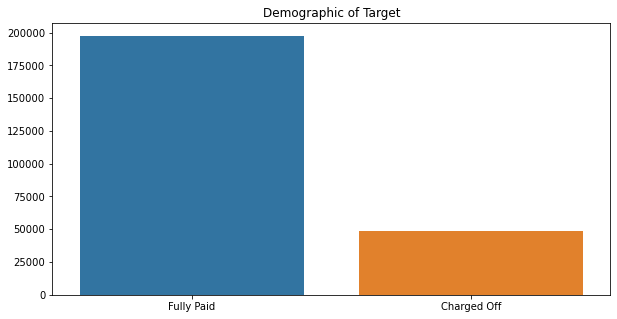

In [6]:
# creating a visual to represent the distribution of our response variable

target = Working_DF['loan_status'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(target.index, target.values).set_title('Demographic of Target')
#plt.savefig('Target_bar')

Key Points: 

- As we already established we do not have any missing values, and we have binned our response variables into Fully Paid and Charged Off

- We have a class imbalance of almost 150k

Consideration(s):

- To deal with the class imbalance we will apply either undersampling the majority class or application of SMOTE (Synthetic Minority Oversampling Technique). This will come up again during the pre-processing section later.

# Bivariant Analysis with Respect to the Response variable

In this section we will explore the relationship between our feature variables within our asset with respect to our response/target variable. 

* Note, we will also be apply some feature engineer and data manipulation throughout.

### Helper functions for analysis

In [7]:
# Creating a function for visualizations for Bi-variant analysis

def plot_var(col_name, full_name, continuous):
    """
    This function is meant to help show features and the relationship to the target (loan_status).
    - col_name, variable name within the df
    - full_name, name of the variable/title 
    - continuous, True if continuous; False if categorical
    """
    f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))
    
    
    # Plot without loan status
    if continuous:
        sns.distplot(Working_DF.loc[Working_DF[col_name].notnull(), col_name], kde=False, ax=ax1)
        plt.xticks(rotation=90, horizontalalignment='center')
    else:
        sns.countplot(Working_DF[col_name], order=sorted(Working_DF[col_name].unique()), ax=ax1)
        ax1.set_xlabel(full_name)
        ax1.set_ylabel('Count')
        plt.xticks(rotation=90, horizontalalignment='center')
        ax1.set_title(full_name)
        
    

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=Working_DF, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
        plt.xticks(rotation=45, horizontalalignment='right')
    else:
        charge_off_rates = Working_DF.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
        plt.xticks(rotation=45, horizontalalignment='right')
        ax2.set_xlabel(full_name)
    
    plt.show()
    
    

In [8]:
## function created for PDF of continous variables and target

def pdf_cont(col_name, full_name):

    fig = plt.subplots(figsize=(6, 6))
    Working_DF.groupby(['loan_status'])[col_name].plot(kind='kde', legend=True)
    plt.title(full_name);

# Because the classes are imbalanced, I think 'kde' is more preferred than 'hist' here.

In [9]:
## function for descrip stats for loan_status

def quick_stats(col_name):
    print(Working_DF.groupby('loan_status')[col_name].describe())

In [10]:
# getting all the variables in the asset

Working_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246269 entries, 0 to 246268
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             246269 non-null  float64
 1   term                  246269 non-null  object 
 2   int_rate              246269 non-null  float64
 3   installment           246269 non-null  float64
 4   grade                 246269 non-null  object 
 5   sub_grade             246269 non-null  object 
 6   emp_length            246269 non-null  int64  
 7   home_ownership        246269 non-null  object 
 8   annual_inc            246269 non-null  float64
 9   verification_status   246269 non-null  object 
 10  issue_d               246269 non-null  object 
 11  loan_status           246269 non-null  object 
 12  purpose               246269 non-null  object 
 13  addr_state            246269 non-null  object 
 14  dti                   246269 non-null  float64
 15  

In [11]:
## Categorical reference

categorical = Working_DF.select_dtypes('object')
categorical.describe()

,term,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,purpose,addr_state,initial_list_status,application_type
count,246269,246269,246269,246269,246269,246269,246269,246269,246269,246269,246269
unique,2,7,35,4,3,77,2,13,51,2,2
top,36 months,C,C1,MORTGAGE,Source Verified,Mar-2016,Fully Paid,debt_consolidation,CA,w,Individual
freq,183412,71260,15641,126956,102862,8711,197386,145597,34771,150365,241649


In [12]:
# checking column names
categorical.columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state',
       'initial_list_status', 'application_type'],
      dtype='object')

In [13]:
## Continous Reference

continous = Working_DF.select_dtypes('number').head()
continous.describe()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,tot_cur_bal,mort_acc,pub_rec_bankruptcies,annual_inc_log,fico_score
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000
mean,16190.000000,16.616000,492.000000,4.000000,63862.000000,22.67000,1997.000000,15.20000,0.200000,18752.600000,57.420000,193589.800000,1.600000,0.200000,11.014052,675.00000
std,8119.759849,5.334658,256.180065,3.464102,23251.617578,4.73933,6.284903,7.79102,0.447214,15144.788024,22.605464,84796.686505,0.894427,0.447214,0.351334,14.40486
min,6950.000000,11.530000,243.930000,1.000000,41810.000000,17.25000,1988.000000,6.00000,0.000000,7459.000000,25.300000,62916.000000,0.000000,0.000000,10.640891,662.00000
25%,10000.000000,12.690000,329.910000,3.000000,45000.000000,19.41000,1995.000000,9.00000,0.000000,9269.000000,56.300000,173292.000000,2.000000,0.000000,10.714418,667.00000
50%,15000.000000,15.880000,440.190000,3.000000,65000.000000,22.22000,1996.000000,16.00000,0.000000,10723.000000,58.000000,197096.000000,2.000000,0.000000,11.082143,667.00000
75%,24000.000000,17.990000,542.280000,3.000000,67500.000000,25.24000,2003.000000,20.00000,0.000000,22654.000000,58.300000,253377.000000,2.000000,0.000000,11.119883,682.00000
max,25000.000000,24.990000,903.690000,10.000000,100000.000000,29.23000,2003.000000,25.00000,1.000000,43658.000000,89.200000,281268.000000,2.000000,1.000000,11.512925,697.00000


In [14]:
# checking column names
continous.columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'tot_cur_bal', 'mort_acc', 'pub_rec_bankruptcies',
       'annual_inc_log', 'fico_score'],
      dtype='object')

## Continous Variables

## Loan Amount

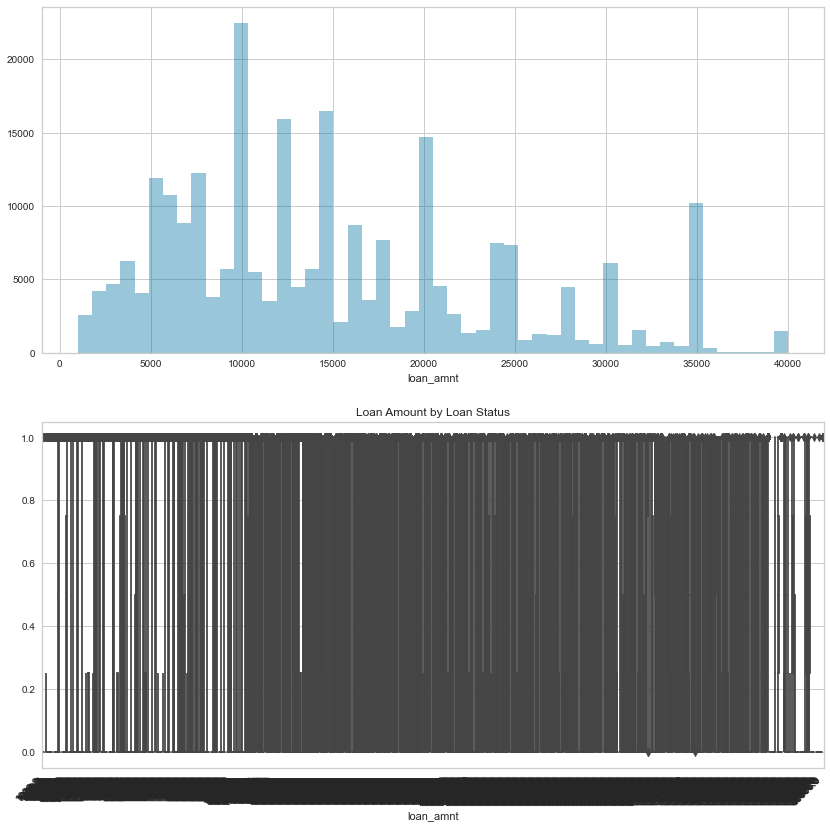

                count          mean          std     min      25%      50%  \
loan_status                                                                  
0            197386.0  14534.892419  8756.550535  1000.0   8000.0  12000.0   
1             48883.0  16091.673997  8826.185411  1000.0  10000.0  15000.0   

                 75%      max  
loan_status                    
0            20000.0  40000.0  
1            21000.0  40000.0  


In [114]:
## Distribution of the variable and to Loan Status

plot_var('loan_amnt', 'Loan Amount', continuous=True)

# quick stats
quick_stats('loan_amnt')

In [16]:
# quick stats
quick_stats('loan_amnt')

                count          mean          std     min      25%      50%  \
loan_status                                                                  
Charged Off   48883.0  16091.673997  8826.185411  1000.0  10000.0  15000.0   
Fully Paid   197386.0  14534.892419  8756.550535  1000.0   8000.0  12000.0   

                 75%      max  
loan_status                    
Charged Off  21000.0  40000.0  
Fully Paid   20000.0  40000.0  


Key Point:

* Per the visual analysis and descriptive stats we can see that charge off tend to have higher loan amounts

## Interest Rate

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


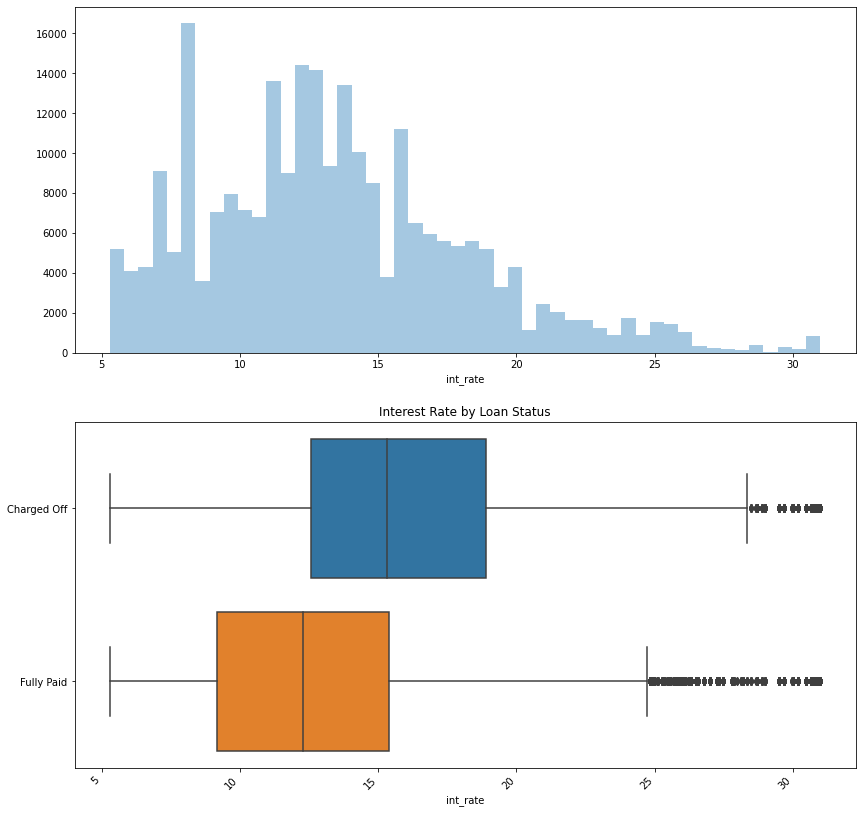

                count       mean       std   min    25%    50%    75%    max
loan_status                                                                 
Charged Off   48883.0  15.901148  4.927393  5.31  12.59  15.31  18.92  30.99
Fully Paid   197386.0  12.765627  4.585788  5.31   9.17  12.29  15.41  30.99


In [17]:
## Distribution of the variable and to Loan Status

plot_var('int_rate', 'Interest Rate', continuous=True)

# quick stats
quick_stats('int_rate')

Key Point:

* Again we can see the higher the interest rate, the greater the possibility of a borrower defaulting  

## Installment

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


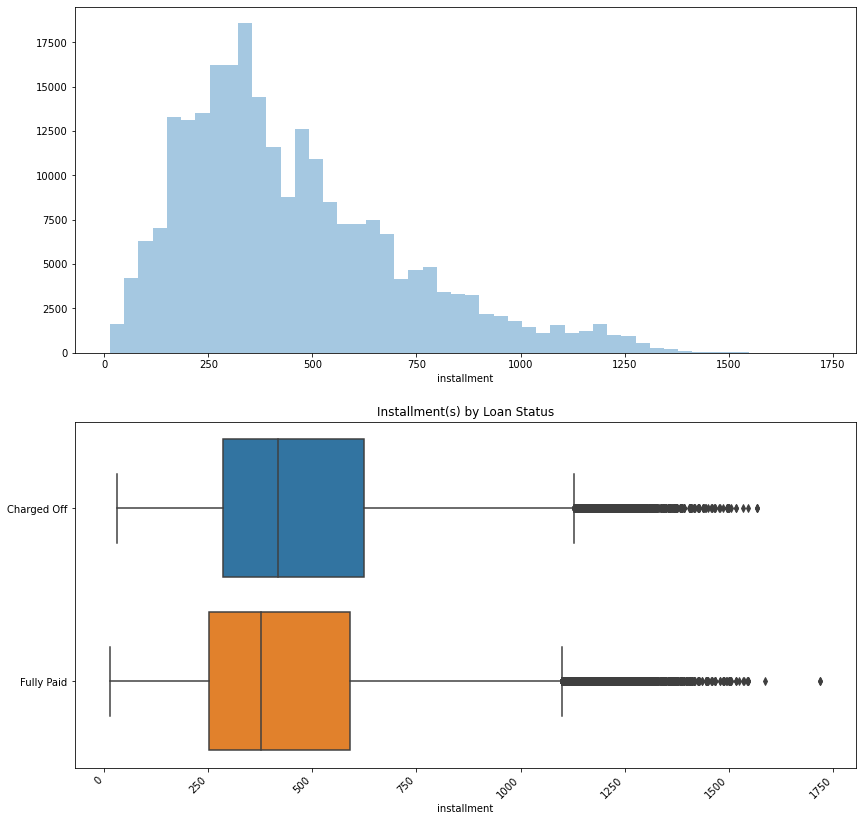

                count        mean         std    min     25%     50%  \
loan_status                                                            
Charged Off   48883.0  479.051801  263.794481  31.33  286.30  417.82   
Fully Paid   197386.0  442.889927  263.276404  14.01  250.66  377.63   

                  75%      max  
loan_status                     
Charged Off  623.2000  1566.80  
Fully Paid   590.0375  1719.83  


In [18]:
## Distribution of the variable and to Loan Status

plot_var('installment', 'Installment(s)', continuous=True)

# quick stats
quick_stats('installment')

Key Points:

* Charge off have higher installments.

* Charge off loans have almost 37 point higher installment per average

## Employment Length

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


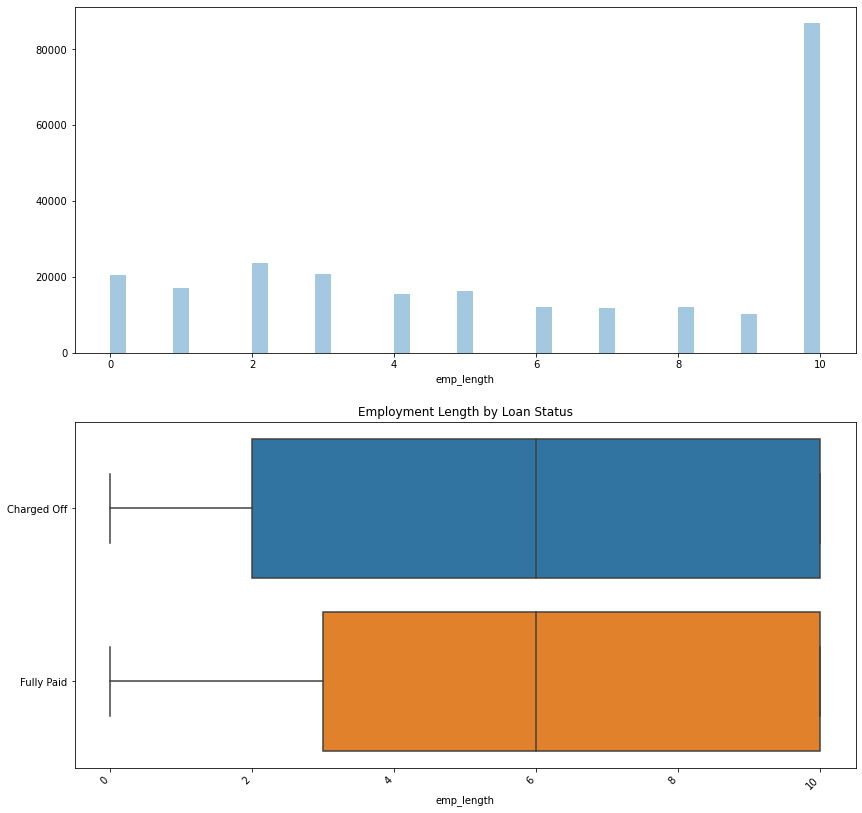

                count      mean       std  min  25%  50%   75%   max
loan_status                                                         
Charged Off   48883.0  5.865863  3.702363  0.0  2.0  6.0  10.0  10.0
Fully Paid   197386.0  6.042019  3.682635  0.0  3.0  6.0  10.0  10.0


In [19]:
## Distribution of the variable and to Loan Status

plot_var('emp_length', 'Employment Length', continuous=True)

# quick stats
quick_stats('emp_length')

Key Points: 

* This quite interesting to see that a borrowers employment length isn't truly indicative of potentially defaulting.

* The summary stats does show that there is a one year difference in average.

Consideration(s):

* Employment length doesn't necessary mean credit worthiness. We can also apply domain knowledge in terms of employment type--some industries pay more than others. Example would be a first year analyst at a small firm may make 50,000 while an investment bank analyst could make 75,000

## Annual Income

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


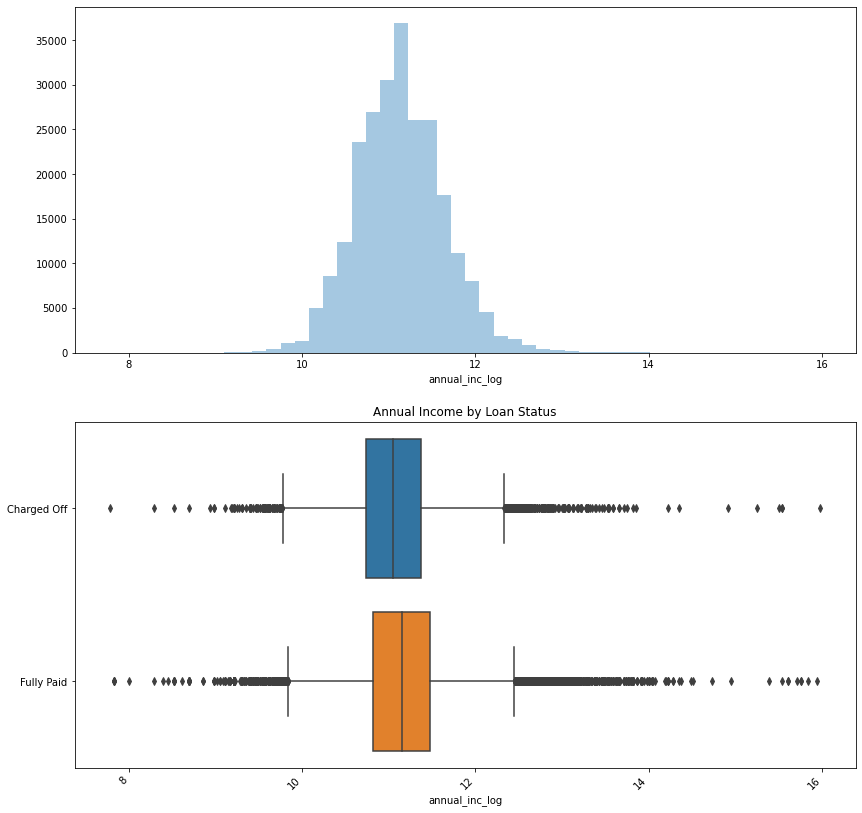

                count       mean       std       min        25%        50%  \
loan_status                                                                  
Charged Off   48883.0  11.069734  0.495624  7.783224  10.736397  11.050890   
Fully Paid   197386.0  11.153513  0.517710  7.824046  10.819778  11.156251   

                   75%        max  
loan_status                        
Charged Off  11.373663  15.979590  
Fully Paid   11.472103  15.943742  


In [20]:
## Distribution of the variable and to Loan Status

plot_var('annual_inc_log', 'Annual Income', continuous=True)

# quick stats
quick_stats('annual_inc_log')



In [21]:
### Checking correlation

Working_DF[['annual_inc','annual_inc_log']].corr()

,annual_inc,annual_inc_log
annual_inc,1.000000,0.681675
annual_inc_log,0.681675,1.000000


Key Points: 

* We can see that fully paid borrowers tend to have a higher income

Consideration(s):

* At this point looking at the correlation between annual_inc and annual_inc_log, I will likely drop annual income from the our variable list within the asset. This will happen during pre processing

## Debt to Income Ratio

In [22]:
# quick stats
quick_stats('dti')


                count       mean        std  min    25%    50%    75%     max
loan_status                                                                  
Charged Off   48883.0  20.520148  10.072991  0.0  14.12  20.17  26.64  999.00
Fully Paid   197386.0  18.194616   8.966026 -1.0  12.00  17.58  23.83  771.31


Key Points:

* As initially mentioned: Domain knowledge dti, should be smaller than 36%, with no more than 28% of that debt going towards servicing your mortgage. 

* The ratio of both charge off and fully paid fall between 28%-36%. However, fully paid borrowers are under by two points in dti compared to charge off borrowers. 
    

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


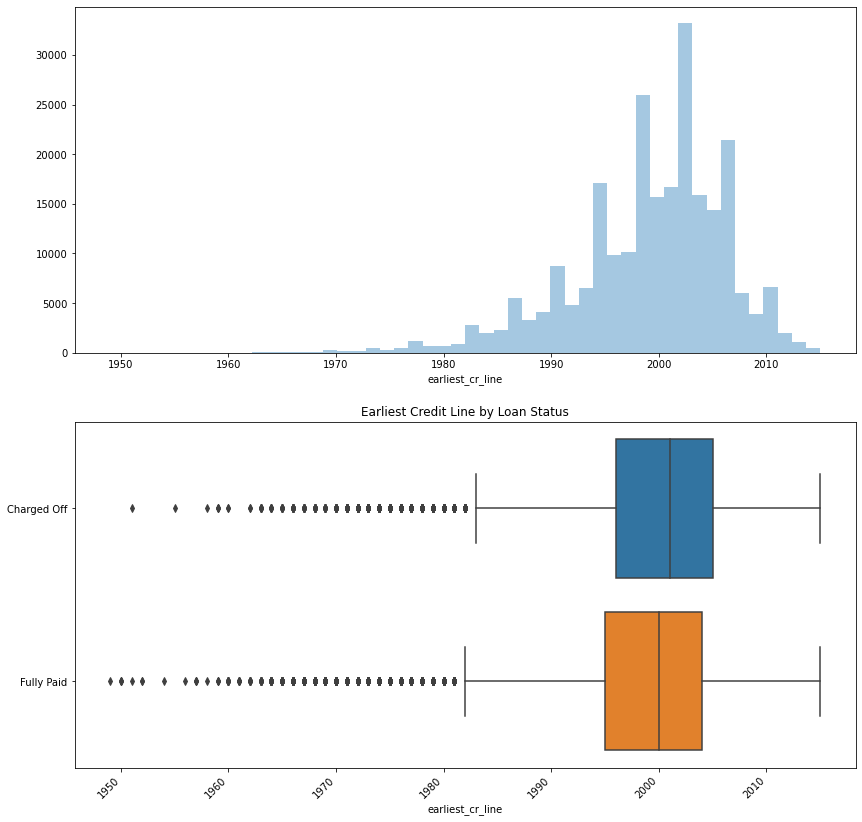

                count         mean       std     min     25%     50%     75%  \
loan_status                                                                    
Charged Off   48883.0  1999.899495  7.070766  1951.0  1996.0  2001.0  2005.0   
Fully Paid   197386.0  1998.981929  7.261071  1949.0  1995.0  2000.0  2004.0   

                max  
loan_status          
Charged Off  2015.0  
Fully Paid   2015.0  


In [23]:
## Distribution of the variable and to Loan Status

plot_var('earliest_cr_line', 'Earliest Credit Line', continuous=True)

# quick stats
quick_stats('earliest_cr_line')

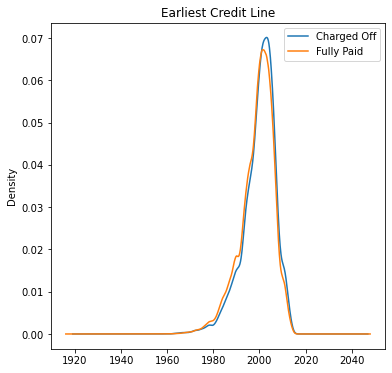

In [24]:
# KDE

pdf_cont('earliest_cr_line', 'Earliest Credit Line')

Key points:

* Again per the boxplot we can see that borrowers that end up in charge off have a short credit history.

## Open Accounts

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


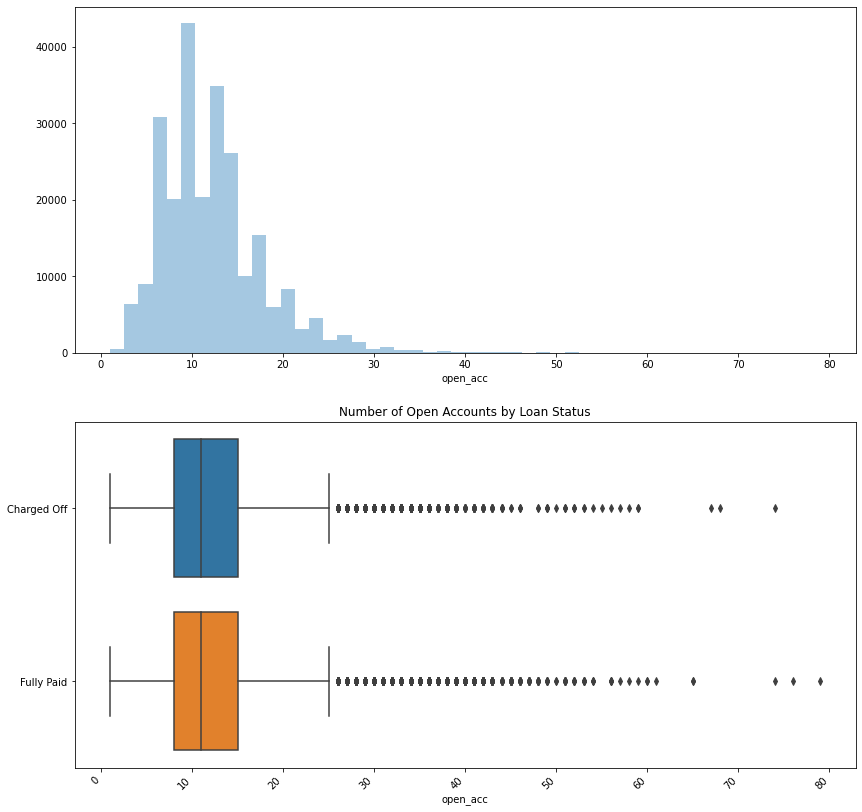

                count       mean       std  min  25%   50%   75%   max
loan_status                                                           
Charged Off   48883.0  12.472086  5.710321  1.0  8.0  11.0  15.0  74.0
Fully Paid   197386.0  12.085741  5.506202  1.0  8.0  11.0  15.0  79.0


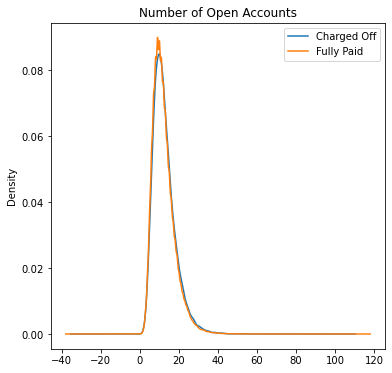

In [25]:
## Distribution of the variable and to Loan Status

plot_var('open_acc', 'Number of Open Accounts', continuous=True)

# quick stats
quick_stats('open_acc')

# KDE

pdf_cont('open_acc', 'Number of Open Accounts')

Key points:

* Per the analytics above there seems to be no significant difference regarding open accounts.

## FICO Score

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


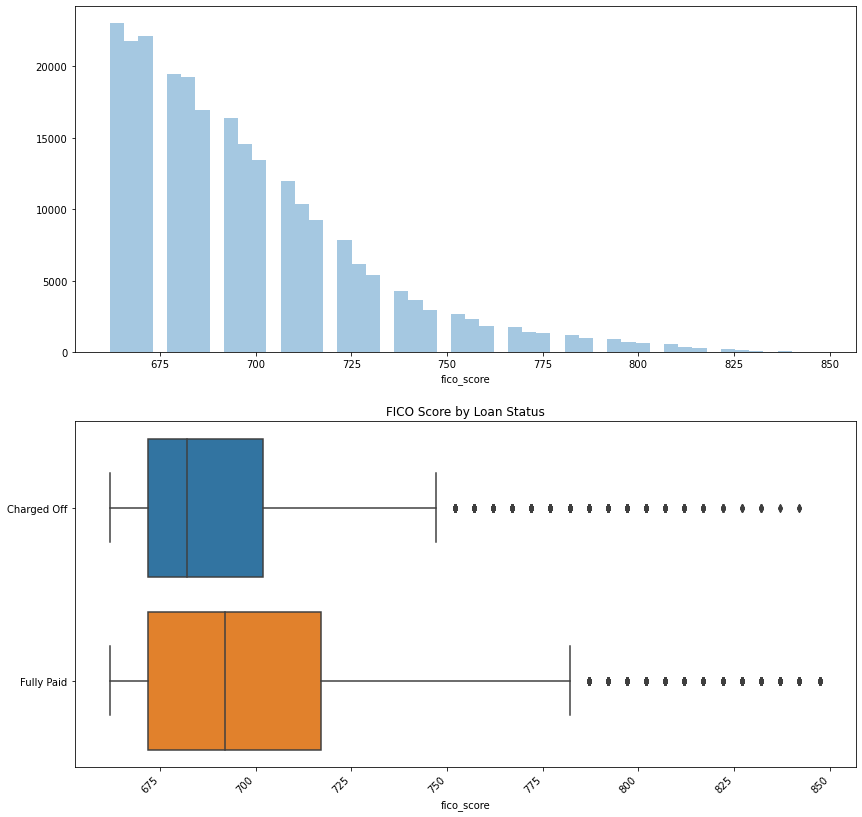

                count        mean        std    min    25%    50%    75%  \
loan_status                                                                
Charged Off   48883.0  689.188286  25.078074  662.0  672.0  682.0  702.0   
Fully Paid   197386.0  699.010084  32.015036  662.0  672.0  692.0  717.0   

               max  
loan_status         
Charged Off  842.0  
Fully Paid   847.5  


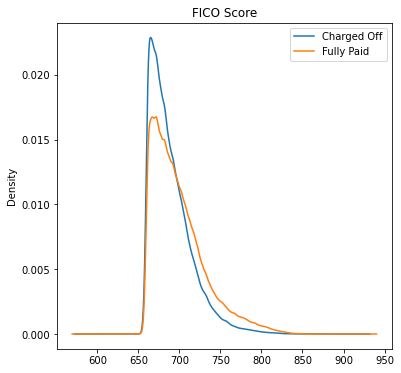

In [26]:
## Distribution of the variable and to Loan Status

plot_var('fico_score', 'FICO Score', continuous=True)

# quick stats
quick_stats('fico_score')

# KDE

pdf_cont('fico_score', 'FICO Score')

Key Points: 

* As we mentioned in our initial EDA notebook, that FICO score is a high indicator of a borrowers credit worthiness.

* The assumption was correct and is indicated above that clients with a higher FICO score are likely to bay back their loan.

## Summary  of  Bi-Variant of Continuous Variables

In regard, to keeping on schedule with the deadline of this initiative we explored some of the key continuous variables with respect to the response variable. 

Quick Recap:

Need to talk about significant finding

## Categorical Variables

### Grade and Sub-Grade

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


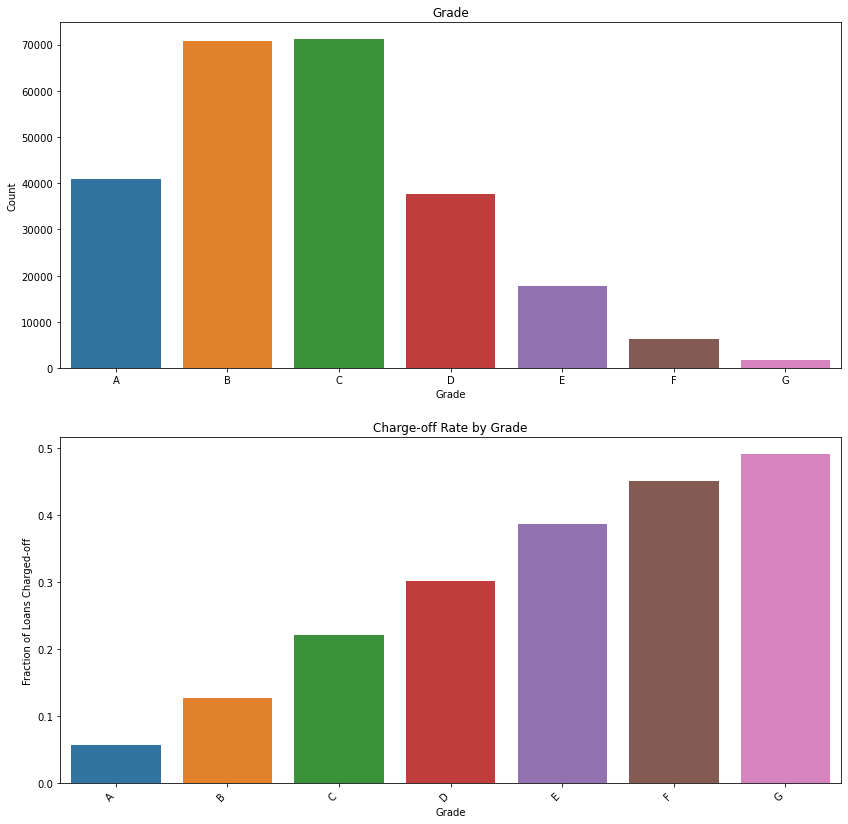

              count unique top   freq
loan_status                          
Charged Off   48883      7   C  15688
Fully Paid   197386      7   B  61686


In [27]:
## Distribution of the variable and to Loan Status

plot_var('grade', 'Grade', continuous=False)

# quick stats
quick_stats('grade')


/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


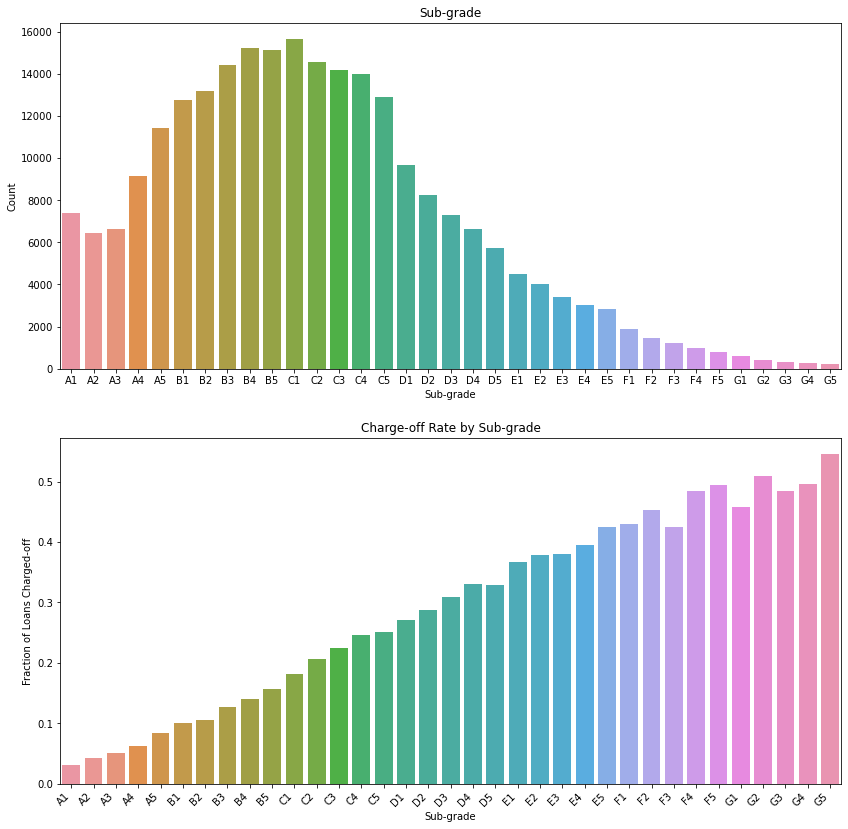

              count unique top   freq
loan_status                          
Charged Off   48883     35  C4   3451
Fully Paid   197386     35  B4  13090


In [28]:
## Distribution of the variable and to Loan Status

plot_var('sub_grade', 'Sub-grade', continuous=False)

# quick stats
quick_stats('sub_grade')


Key points:

* There seems to be a trend regarding charge offs and sub-grade. 

* As as the grade goes up the likelihood the borrower will default.

Consideration(s):

* During the pre-processing section one I will drop one of these features

### Home Ownership

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


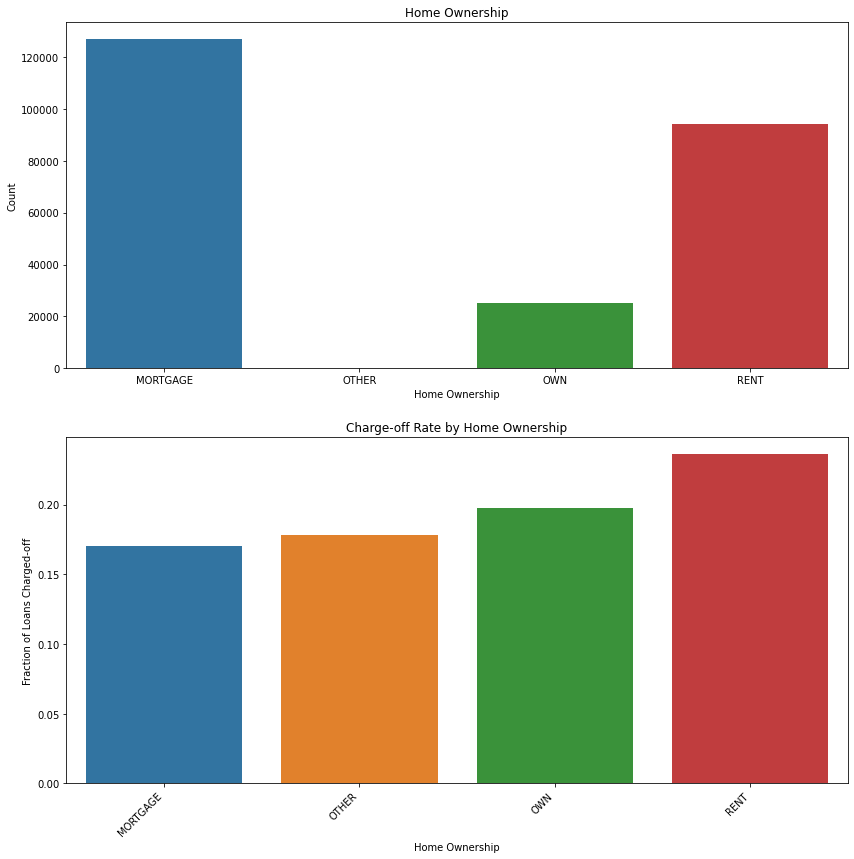

              count unique       top    freq
loan_status                                 
Charged Off   48883      4      RENT   22234
Fully Paid   197386      4  MORTGAGE  105294


In [29]:
## Distribution of the variable and to Loan Status

plot_var('home_ownership', 'Home Ownership', continuous=False)

# quick stats
quick_stats('home_ownership')


Key points:

* We can see borrowers who are renters are likely to default. 
* This is also interesting to see home owners are also in the high range of potentially defaulting

### Purpose

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


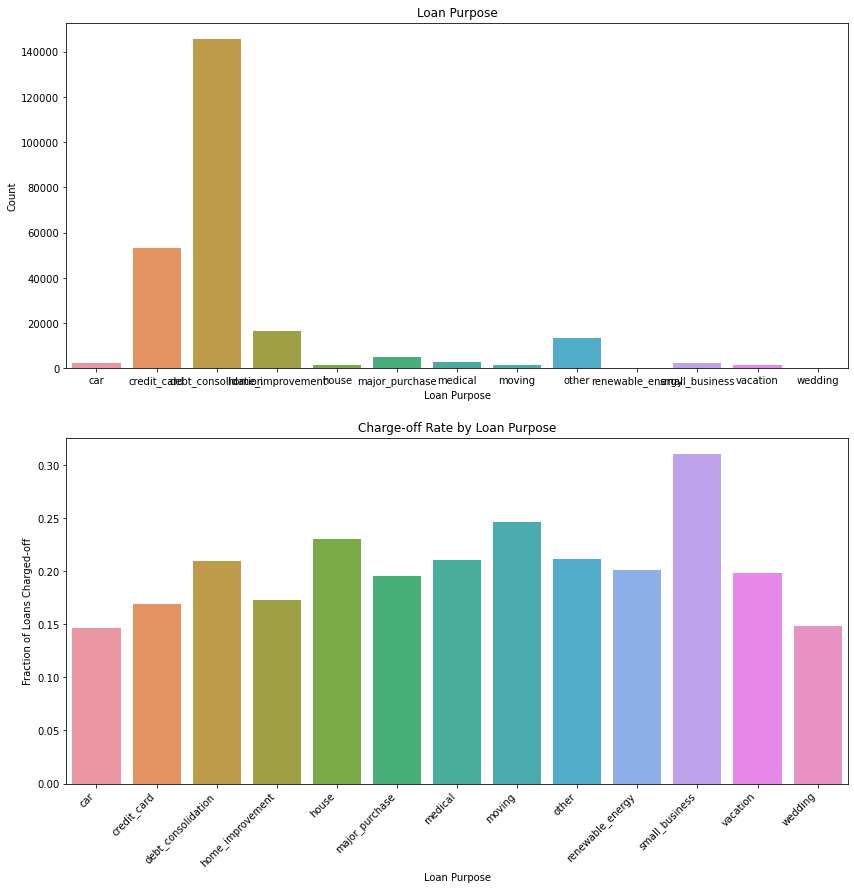

              count unique                 top    freq
loan_status                                           
Charged Off   48883     13  debt_consolidation   30452
Fully Paid   197386     13  debt_consolidation  115145


In [30]:
## Distribution of the variable and to Loan Status

plot_var('purpose', 'Loan Purpose', continuous=False)

# quick stats
quick_stats('purpose')

Key points:

* This actually proved to be very informative in regard to my initial assumption, that debt_consolidation and credit_card would be high for charge off borrowers. 

* Almost 30% of charge offs are due to small business. That being said, per intuition, this seems quite correct due to the volatility of potential small business. Business come and go, some have great success, some do not.   

### Application Type (Individual and Joint)

/Users/B_A_S_i_C/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


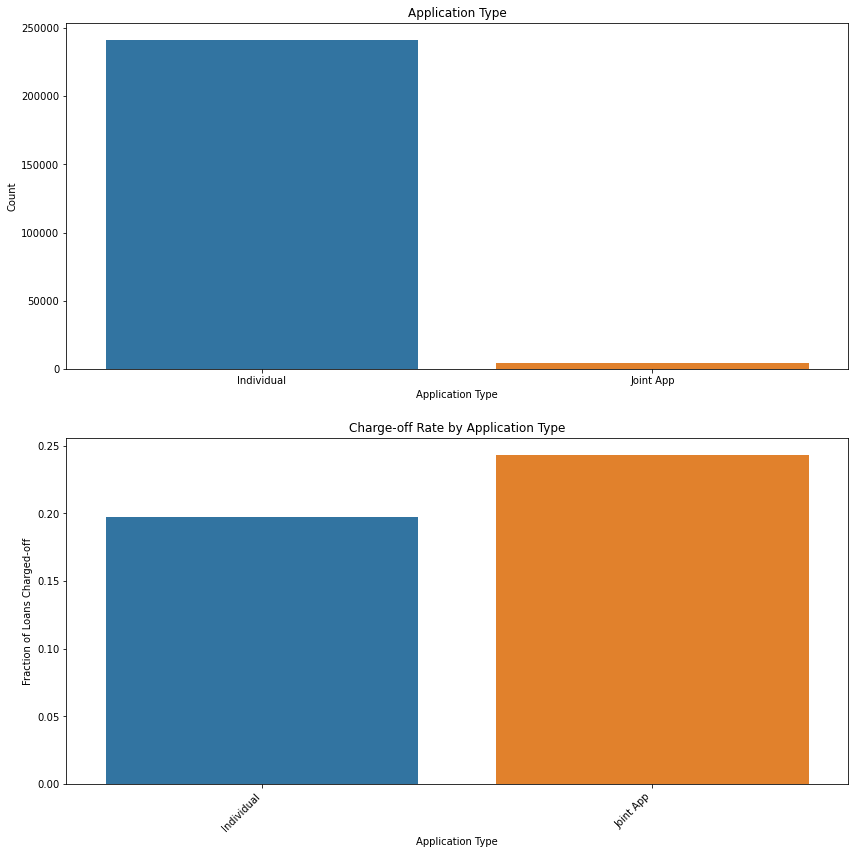

              count unique         top    freq
loan_status                                   
Charged Off   48883      2  Individual   47758
Fully Paid   197386      2  Individual  193891


In [31]:
## Distribution of the variable and to Loan Status

plot_var('application_type', 'Application Type', continuous=False)

# quick stats
quick_stats('application_type')

Key points:

* Very interesting again, as this has disproved my initial assumptions about application type. Surprisingly, joint applicants have a higher percentage of defaulting.  

## Summary of Bi-Variant of Catagorical Vairables 

This portion of the analysis has been the most surprising and quite informative. 

Quick Recap:

talk talk


# Pre-processing

## Reducing the feature space

In [32]:
# checking the current features

Working_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246269 entries, 0 to 246268
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             246269 non-null  float64
 1   term                  246269 non-null  object 
 2   int_rate              246269 non-null  float64
 3   installment           246269 non-null  float64
 4   grade                 246269 non-null  object 
 5   sub_grade             246269 non-null  object 
 6   emp_length            246269 non-null  int64  
 7   home_ownership        246269 non-null  object 
 8   annual_inc            246269 non-null  float64
 9   verification_status   246269 non-null  object 
 10  issue_d               246269 non-null  object 
 11  loan_status           246269 non-null  object 
 12  purpose               246269 non-null  object 
 13  addr_state            246269 non-null  object 
 14  dti                   246269 non-null  float64
 15  

In [33]:
# Dropping some features

Working_DF.drop(['grade', 'annual_inc'], axis=1, inplace=True)

In [34]:
# sanity check

Working_DF.shape

(246269, 25)

In [35]:
# dropping more feature

Working_DF.drop(['issue_d', 'addr_state', 'initial_list_status'], axis=1, inplace=True)

In [36]:
#Sanity check

Working_DF.shape

(246269, 22)

### Multi-collinearity

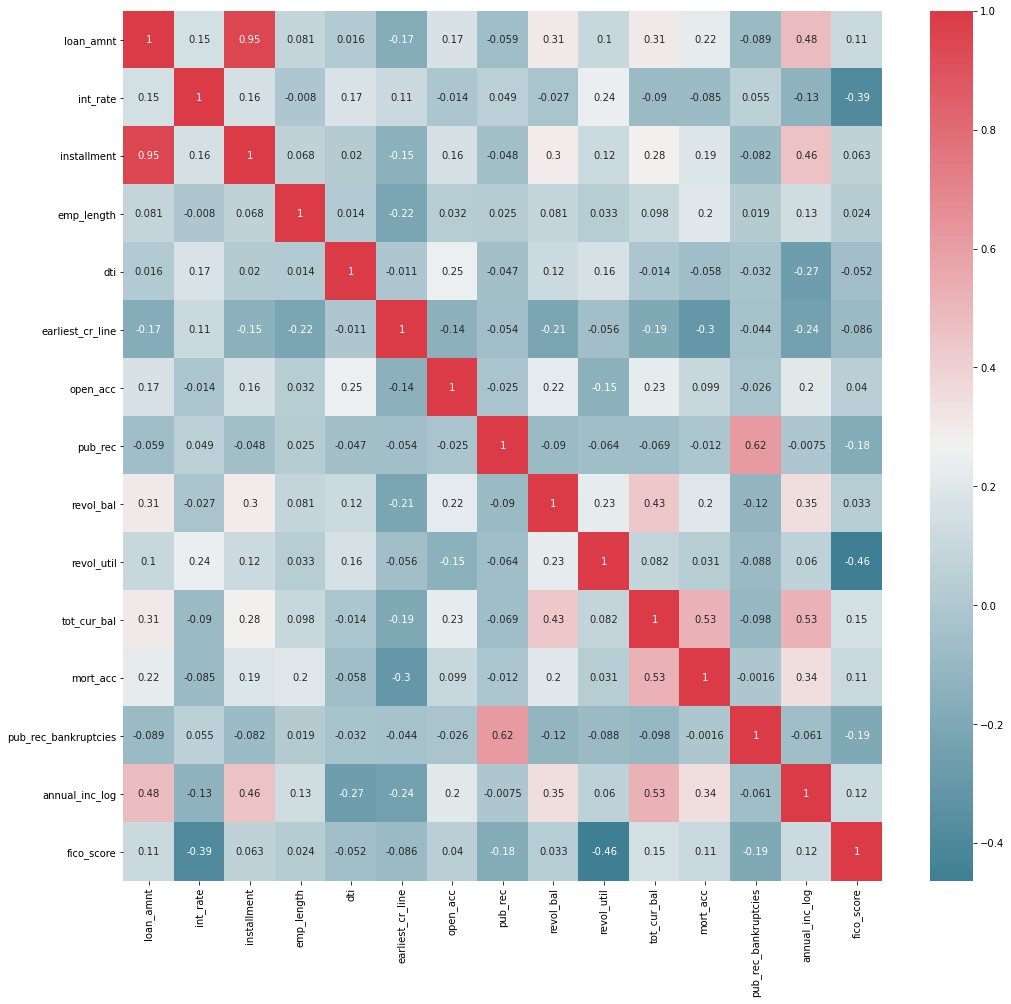

In [37]:
# checking correlation

def correlation_heatmap(df1):
   _,ax=plt.subplots(figsize=(17,16))
   colormap=sns.diverging_palette(220,10,as_cmap=True)
   sns.heatmap(Working_DF.corr(),annot=True,cmap=colormap)
   
correlation_heatmap(Working_DF)

In [38]:
# dropping highly correlated feature

Working_DF.drop(['installment'], axis=1, inplace=True)

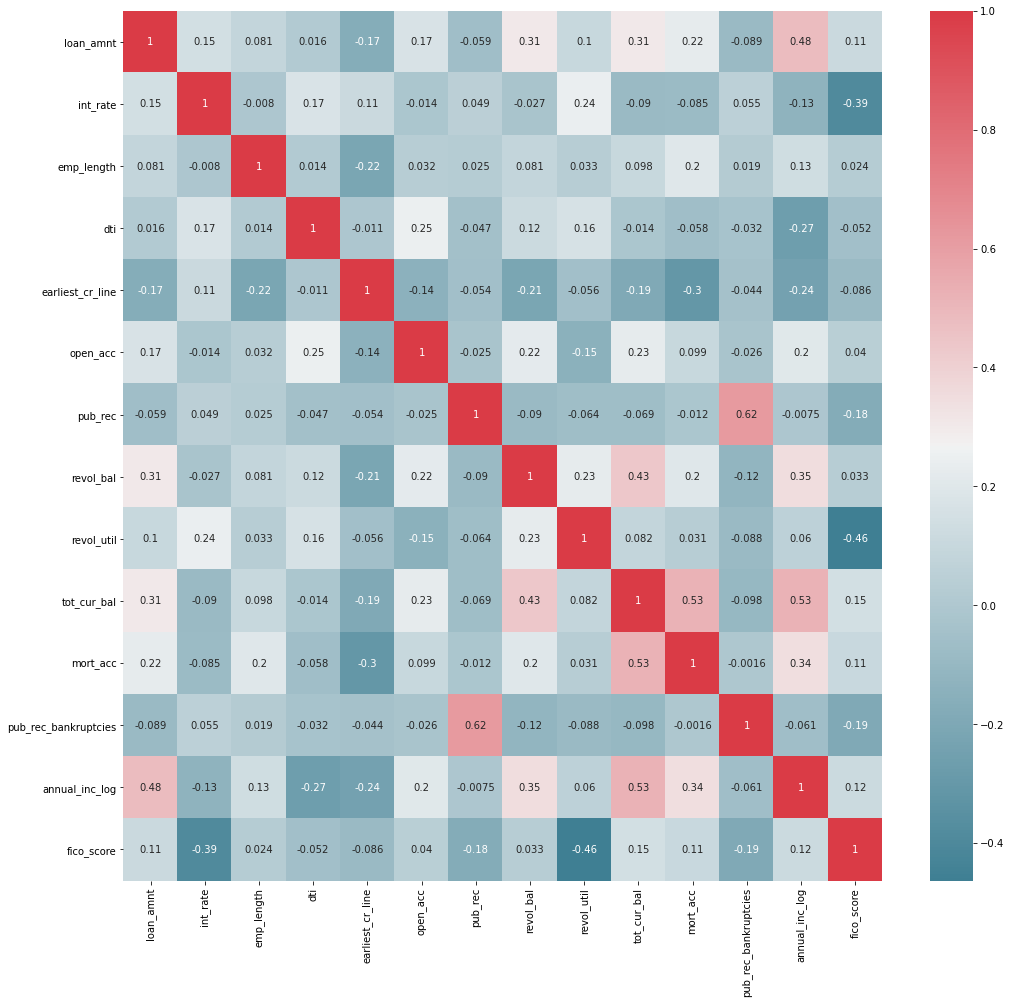

In [39]:
# checking for correlation

correlation_heatmap(Working_DF)

In [40]:
# checking all the vaiables

Working_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246269 entries, 0 to 246268
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             246269 non-null  float64
 1   term                  246269 non-null  object 
 2   int_rate              246269 non-null  float64
 3   sub_grade             246269 non-null  object 
 4   emp_length            246269 non-null  int64  
 5   home_ownership        246269 non-null  object 
 6   verification_status   246269 non-null  object 
 7   loan_status           246269 non-null  object 
 8   purpose               246269 non-null  object 
 9   dti                   246269 non-null  float64
 10  earliest_cr_line      246269 non-null  int64  
 11  open_acc              246269 non-null  float64
 12  pub_rec               246269 non-null  float64
 13  revol_bal             246269 non-null  float64
 14  revol_util            246269 non-null  float64
 15  

Key Points:

* Base on the heatmap we were able to reduce some of the feature that were highly correlated.

* We also removed some categorical features that were good for our EDA, but may not be useful in modeling. 

### Feature Engineering

In [41]:
# Creating the binary for our reponse variable

Working_DF['loan_status'] = Working_DF['loan_status'].replace('Charged Off',1)
Working_DF['loan_status'] = Working_DF['loan_status'].replace('Fully Paid',0)

In [42]:
# Sanity Check

Working_DF['loan_status'].value_counts()

0    197386
1     48883
Name: loan_status, dtype: int64

In [43]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler

## Dummy out categorical features

df_dummy = pd.get_dummies(Working_DF, columns=['term', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'application_type'], drop_first=True)

In [44]:
df_dummy.head()

,loan_amnt,int_rate,emp_length,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,tot_cur_bal,mort_acc,pub_rec_bankruptcies,annual_inc_log,fico_score,term_ 60 months,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App
0,25000.0,17.99,1,1,19.41,1995,25.0,0.0,43658.0,56.3,173292.0,2.0,0.0,11.119883,662.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000.0,11.53,3,0,29.23,2003,20.0,0.0,7459.0,58.3,62916.0,0.0,0.0,10.714418,682.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,6950.0,15.88,3,0,17.25,1988,6.0,1.0,10723.0,58.0,197096.0,2.0,1.0,10.640891,667.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,24000.0,12.69,3,0,22.22,1996,9.0,0.0,22654.0,89.2,281268.0,2.0,0.0,11.512925,697.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15000.0,24.99,10,0,25.24,2003,16.0,0.0,9269.0,25.3,253377.0,2.0,0.0,11.082143,667.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [45]:
## Continous Reference

continous = Working_DF.select_dtypes('number').head()
continous.columns

Index(['loan_amnt', 'int_rate', 'emp_length', 'loan_status', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'tot_cur_bal', 'mort_acc', 'pub_rec_bankruptcies', 'annual_inc_log',
       'fico_score'],
      dtype='object')

In [46]:
# Converting all floats into whole numbers

df_dummy = df_dummy.astype({'loan_amnt': 'int', 'int_rate' : 'int', 'emp_length': 'int', 
                            'loan_status' : 'int', 'dti': 'int','earliest_cr_line' : 'int', 
                            'open_acc' : 'int', 'pub_rec': 'int', 'revol_bal': 'int', 
                            'revol_util' : 'int', 'tot_cur_bal' : 'int', 'mort_acc': 'int', 
                            'pub_rec_bankruptcies': 'int', 'annual_inc_log': 'int','fico_score': 'int'}) 

In [47]:
#Sanity Check

df_dummy.head()

,loan_amnt,int_rate,emp_length,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,tot_cur_bal,mort_acc,pub_rec_bankruptcies,annual_inc_log,fico_score,term_ 60 months,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App
0,25000,17,1,1,19,1995,25,0,43658,56,173292,2,0,11,662,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000,11,3,0,29,2003,20,0,7459,58,62916,0,0,10,682,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,6950,15,3,0,17,1988,6,1,10723,58,197096,2,1,10,667,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,24000,12,3,0,22,1996,9,0,22654,89,281268,2,0,11,697,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15000,24,10,0,25,2003,16,0,9269,25,253377,2,0,11,667,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [48]:
#Sanity Check

df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246269 entries, 0 to 246268
Data columns (total 68 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   loan_amnt                            246269 non-null  int64
 1   int_rate                             246269 non-null  int64
 2   emp_length                           246269 non-null  int64
 3   loan_status                          246269 non-null  int64
 4   dti                                  246269 non-null  int64
 5   earliest_cr_line                     246269 non-null  int64
 6   open_acc                             246269 non-null  int64
 7   pub_rec                              246269 non-null  int64
 8   revol_bal                            246269 non-null  int64
 9   revol_util                           246269 non-null  int64
 10  tot_cur_bal                          246269 non-null  int64
 11  mort_acc                             24

In [49]:
# Setting up the variables

X = df_dummy.drop(columns='loan_status')
y = df_dummy.loan_status

## Train-Test-Split

In this section we will set up our modeling process and helper functions for post model training analysis. 

Please bear in mind that we may opt to use an additional library called Pycaret to ensure a more robust analysis, save on computing power, and for evaluation for this iteration of this project. 

In [50]:
## Train test split


from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [51]:
# Sanity Check

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(246269, 67)
(197015, 67)
(49254, 67)
(246269,)
(197015,)
(49254,)


In [52]:
# Scaling the asset

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Modeling

###### Note this section is subject to change given computing process limitations or deadline constraints  with respects to Version 1 of this initiative 

Process Workflow for Modeling:

1) Model Selection (analysis, model evaluation) >> 

Baseline Models:

* Logistic Regression
* Support Vector Machine (Classifier)
* Naive Bayes Classifier


2) Tune Model (hyperparamater analysis, model evaluation) >> 

* SMOTE to handle the Class Imbalance
* Applying GridSearchCV for cross validation and best hyper parameters


3) Best Model Evaluation with Commentary

* Best Model Evaluation 
* Key Benchmarks
* Summary (with Next Steps)

In [53]:
# Instanciating the necessary metric libraries

from sklearn.model_selection import KFold,RepeatedStratifiedKFold,GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


### Metric(s) Focus

We will focus on False Negatives as we want to account for all borrowers who would default and not overlook borrowers who were miss categorized. 

* Recall will be or metric emphasis as it is the more valuable indicator in understanding borrowers who will default.

However, we will have two other metrics as a back-up in the likelihood Recall is too low. As we still want this version of the best model to be able to identify our response variable variables.

* Accuracy, to identify how our model is at predicting on the over all asset.

* ROC-AUC, to identify ranking of uniformity of the expected proportion of the true positive rate and false positive rate

Note, we will allow a bit of flexibility in terms of metrics to help come to a determination on the potential next steps following this iteration for the next phase of this initiative 


### Helper function for metrics used for model evaluation

In [54]:
# helper function for metric eval of Test Set

def test_model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Testing Set Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    


In [55]:
# helper function for metric eval Training set

def train_model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred_1 = model.predict(X_train)
    
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_train, y_pred_1)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Testing Set Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_train, y_pred_1))
    


## Baseline Modeling

### Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    157884
           1       0.55      0.06      0.11     39131

    accuracy                           0.80    197015
   macro avg       0.68      0.53      0.50    197015
weighted avg       0.76      0.80      0.74    197015



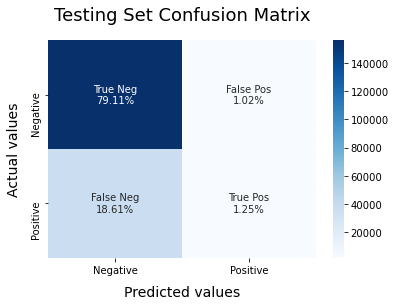

In [56]:
## Fitting the model

Log_reg = LogisticRegression()
Log_reg.fit(X_train, y_train)

# Train Eval
train_model_Evaluate(Log_reg)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     39502
           1       0.56      0.06      0.11      9752

    accuracy                           0.80     49254
   macro avg       0.68      0.52      0.50     49254
weighted avg       0.76      0.80      0.73     49254



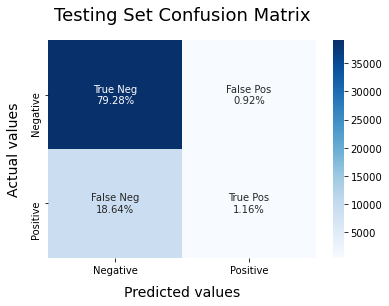

In [57]:
# Test Eval

test_model_Evaluate(Log_reg)

Key Points:

* 80% accuracy, but with very unfavorable results in terms of recall. 

* We see only a 1.2% hit on the True Positive which signals the class imbalance. 


Considerations: 

* Addressing the class imbalance, hopefully it will help in identifying the true postives

### Support Vector Classifier

In [58]:
# from sklearn.svm import SVC

# SVCmodel = SVC()
# SVCmodel.fit(X_train, y_train)

In [59]:
# train_model_Evaluate(SVCmodel)
# test_model_Evaluate(SVCmodel)

## The Need for Speed and External Efficiencies 

At this point in time due to time constraints regarding the project benchmark, we will move forward with Auto Machine Learning.  We will be using PyCaret. 

The word caret originally came from a library in R, called Caret (Classification And REgression Training) created by Max Kuhnwho to help streamline the process of model development. In 2019 Moez Ali and the popular shift from R to Python, recognized the need for a similar tool to do the same within a Python environment. And, that’s how PyCaret was born.

PyCaret is a Python wrapper that has machine learning libraries and frameworks such as scikit-learn, XGBoost, Random Forest, and much more. Again, the library performs end-to-end machine learning experiments, whether that’s imputing missing values, encoding categorical data, feature engineering, hyperparameter tuning, or building ensemble models. Also, all operations performed are stored in a pipeline that is ready for deployment.

* Note, after reporting our initiative's minimum viable product, we will continue to build out baseline, tuned/optimized models, and perform model evaluations via the SKLean module. Again, just to emphasize, PyCaret is supplemental to our modeling process and will play role again in our Phase Two iteration of this initiative. 

# Auto Machine Leanring

In this section we will apply PyCaret (Classification And REgression Training.).

* The reason we are using PyCaret for our modeling and pre-deployment process is due to it's ability to run multiple models at once. Therefore, saving both time and computing power. As seen above when performing models, the time taken for the models to complete are quite time consuming. This is also a great tool to leverage given the scale of the data. *

## Modeling (Auto ML)

Process Workflow for Auto ML Modeling:

1) Model Selection (10 fold cv, hyperparamater tuning/analysis, model evaluation) >> 


2) Tune Model (10 fold cv, hyperparamater analysis, model evaluation) >> 


3) Best Model Evaluation with Commentary

In [60]:
# Pycaret
from pycaret.classification import *

* Setting up the modeling enviroment. Due to the class imbalance of our response variable we use SMOTE


In [61]:
# Eniroment setup
clf = setup(data=df_dummy, target = 'loan_status', fix_imbalance= True, session_id=123)

,Description,Value
0,session_id,123
1,Target,loan_status
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(246269, 68)"
5,Missing Values,False
6,Numeric Features,63
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


## Performance Indicators and Model Comparison

We will prioritize Recall, Accuracy, and AUC


Benchmark indicators: 

* Recall: should be above .45


* Accuracy: equal or above .60


* AUC: should be equal or above .50/.60, ideally over .70 for better balance in predicting our positive class


For the purpose of this version of the initiative we will consider two out of the three benchmark indicators as a green light for model selection. Also, in consideration, if either one metric stands out we will raise the question, if we should include it to our model selection list.

In [62]:
# Model Comparison based on recall

best_model = compare_models(sort = 'Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.1983,0.5000,0.9997,0.1982,0.3308,-0.0000,-0.0017,5.6410
nb,Naive Bayes,0.4492,0.6587,0.8148,0.2391,0.3697,0.0911,0.1478,1.9780
lr,Logistic Regression,0.6008,0.6640,0.6449,0.2809,0.3910,0.1584,0.1883,7.8160
svm,SVM - Linear Kernel,0.6143,0.0000,0.4326,0.2928,0.2586,0.0780,0.0972,18.2330
knn,K Neighbors Classifier,0.5768,0.5273,0.4242,0.2139,0.2844,0.0283,0.0316,6.6440
dt,Decision Tree Classifier,0.7023,0.5508,0.2997,0.2722,0.2853,0.0979,0.0981,5.1950
ada,Ada Boost Classifier,0.7717,0.6637,0.2057,0.3651,0.2630,0.1403,0.1484,16.9730
gbc,Gradient Boosting Classifier,0.7904,0.6920,0.1745,0.4295,0.2481,0.1509,0.1717,73.2410
et,Extra Trees Classifier,0.7944,0.6776,0.1140,0.4299,0.1802,0.1059,0.1368,54.2830
catboost,CatBoost Classifier,0.8036,0.7162,0.1131,0.5215,0.1858,0.1239,0.1718,85.6450


## Models We will prioritize for modeling:

* Light Gradient Boosting Machine, 

with an accuracy of .80, AUC at .07; however, the Recall is low. As we mentioned earlier We will have three metrics to help guide us and LightGBM hits both accuracy and AUC.


* Logistic Regression, 

Accuracy is .60, AUC is .66, and recall is at .64 -- hitting pretty decent scores. Unlike earlier when in our baseline above which was at 80% accuray but the recall on both the test and training set were not very favorable. The reason we could be seeing due to SMOTE


* Naive Bayes, 

with an AUC of .65 and Recall at .81, it's fall within our benchmark indications. However, accuracy at .45, we will allow it for experimental purposes for now. 


## Light Gradient Boosting Machine

In [63]:
# creating the model

lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8011,0.7186,0.0872,0.4901,0.1481,0.0938,0.1400
1,0.8046,0.7163,0.0931,0.5408,0.1588,0.1068,0.1615
2,0.8058,0.7218,0.0939,0.5602,0.1609,0.1102,0.1684
3,0.8031,0.7030,0.0881,0.5190,0.1506,0.0988,0.1501
4,0.8053,0.7231,0.0852,0.5575,0.1478,0.1005,0.1592
5,0.8045,0.7146,0.0855,0.5428,0.1477,0.0991,0.1551
6,0.8029,0.7113,0.0898,0.5160,0.1530,0.1001,0.1507
7,0.8019,0.7214,0.0819,0.5018,0.1409,0.0903,0.1393
8,0.8051,0.7151,0.0951,0.5481,0.1621,0.1099,0.1656
9,0.8047,0.7183,0.0916,0.5434,0.1568,0.1056,0.1610


In [64]:
# hyper param 

print(lightgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [65]:
# tuned model

tuned_lightgbm = tune_model(lightgbm, optimize='Recall' )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6024,0.6481,0.7009,0.2911,0.4113,0.1823,0.2226
1,0.5449,0.6348,0.7837,0.2737,0.4057,0.1585,0.2170
2,0.5390,0.6273,0.7735,0.2693,0.3995,0.1493,0.2049
3,0.5352,0.6233,0.7694,0.2668,0.3962,0.1443,0.1987
4,0.5461,0.6348,0.7817,0.2740,0.4057,0.1588,0.2168
5,0.5327,0.6248,0.7773,0.2669,0.3974,0.1451,0.2014
6,0.5301,0.6239,0.7793,0.2661,0.3967,0.1436,0.2002
7,0.5416,0.6313,0.7799,0.2715,0.4028,0.1541,0.2114
8,0.5391,0.6307,0.7826,0.2708,0.4023,0.1528,0.2107
9,0.5390,0.6311,0.7837,0.2709,0.4026,0.1531,0.2114


In [66]:
#Tuned hyper params

print(tuned_lightgbm)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.0005, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
               n_estimators=30, n_jobs=-1, num_leaves=2, objective=None,
               random_state=123, reg_alpha=0.2, reg_lambda=0.0005, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


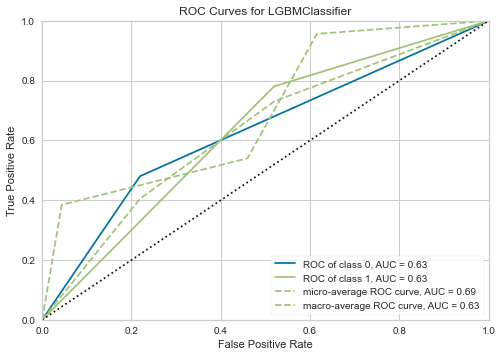

In [67]:
# Tuned ROC

plot_model(tuned_lightgbm, plot = 'auc')

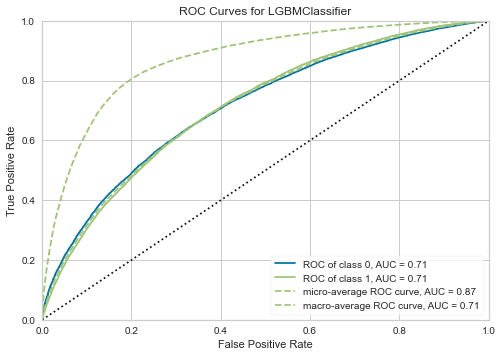

In [68]:
#base model ROC

plot_model(lightgbm, plot = 'auc')

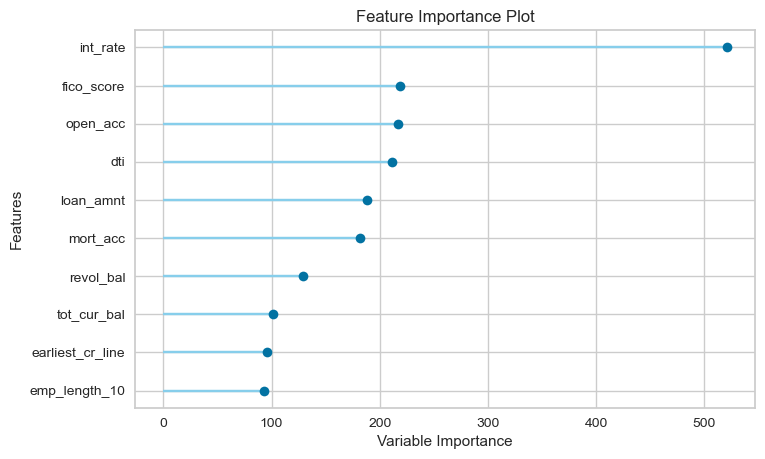

In [69]:
# Feature Importance of base model

plot_model(lightgbm, plot='feature')

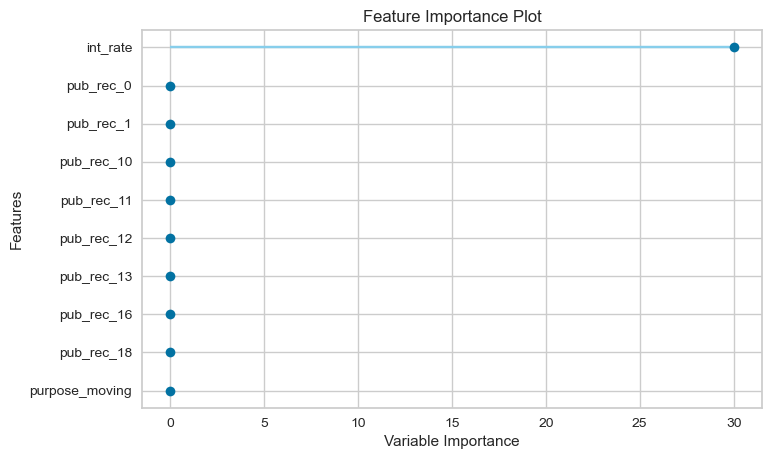

In [70]:
# Feature impportance of tuned model

plot_model(tuned_lightgbm, plot='feature')

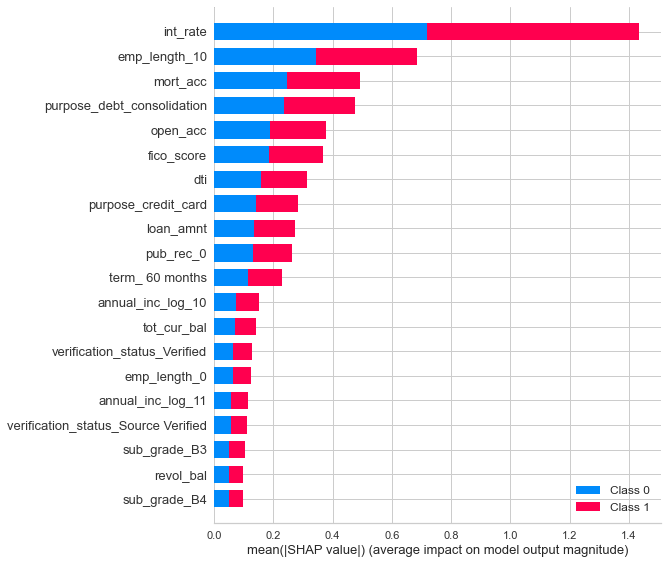

In [71]:
#Model Interprtation

interpret_model(lightgbm)

In [80]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [109]:
(58017*(-12000))+(1151*(-12000))+(13437*120)+(1276*1000000)

567596440

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

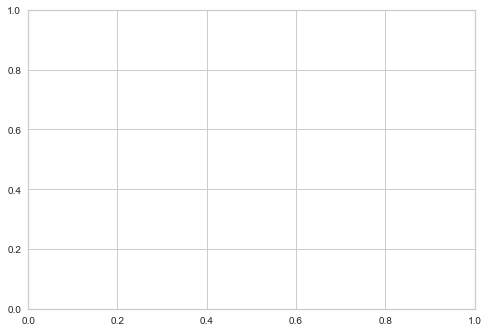

In [81]:
evaluate_model(tuned_lightgbm)

In [110]:
(28416*(-12000))+(30752*(-12000))+(3223*120)+(11490*1000000)

10780370760

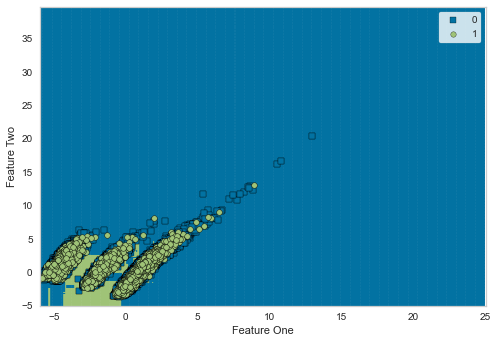

In [111]:
plot_model(lightgbm, plot = 'boundary')

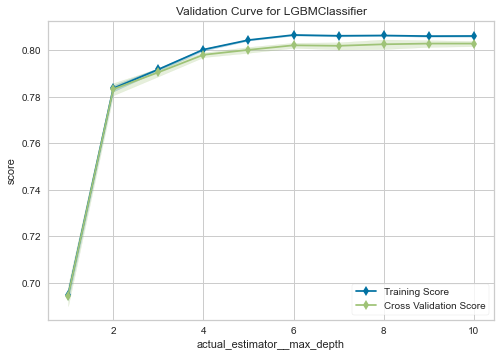

In [112]:
# Validation Curve
plot_model(lightgbm, plot = 'vc')

## Logistic Regression

In [87]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6345,0.6918,0.6465,0.3026,0.4122,0.1948,0.2244
1,0.5611,0.6334,0.6468,0.2579,0.3687,0.1191,0.1488
2,0.6047,0.6718,0.6608,0.2853,0.3986,0.1683,0.2013
3,0.6264,0.6761,0.6289,0.2935,0.4003,0.1781,0.2054
4,0.5660,0.6441,0.6538,0.2618,0.3739,0.1267,0.1579
5,0.5927,0.6556,0.6438,0.2748,0.3852,0.1487,0.1789
6,0.5962,0.6618,0.6415,0.2765,0.3864,0.1513,0.1812
7,0.5697,0.6412,0.6544,0.2639,0.3761,0.1305,0.1620
8,0.6292,0.6846,0.6444,0.2984,0.4079,0.1879,0.2174
9,0.6272,0.6793,0.6277,0.2938,0.4003,0.1784,0.2055


In [88]:
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [92]:
tuned_lr = tune_model(lr, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6347,0.6918,0.6465,0.3026,0.4123,0.1949,0.2245
1,0.5611,0.6334,0.6468,0.2579,0.3687,0.1191,0.1488
2,0.6563,0.7050,0.6339,0.3167,0.4223,0.2148,0.2410
3,0.5888,0.6511,0.6392,0.2716,0.3813,0.1428,0.1722
4,0.5660,0.6441,0.6538,0.2618,0.3739,0.1267,0.1579
5,0.5927,0.6556,0.6438,0.2748,0.3852,0.1487,0.1789
6,0.5950,0.6610,0.6441,0.2763,0.3867,0.1513,0.1815
7,0.5697,0.6412,0.6544,0.2639,0.3761,0.1305,0.1620
8,0.6293,0.6846,0.6444,0.2985,0.4080,0.1880,0.2175
9,0.5952,0.6616,0.6444,0.2765,0.3869,0.1515,0.1819


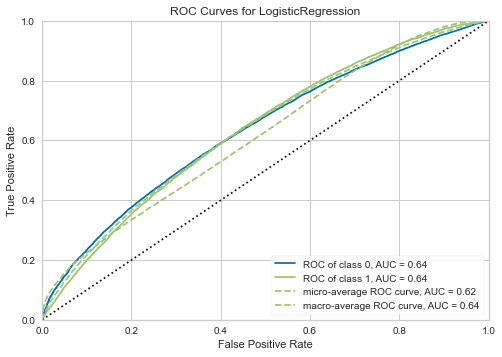

In [94]:
#base model ROC

plot_model(lr, plot = 'auc')

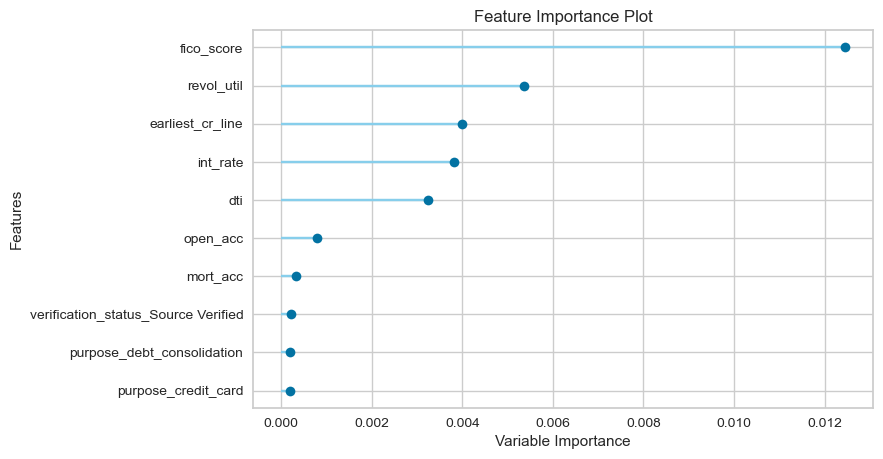

In [95]:
# Feature impportance of base model

plot_model(lr, plot='feature')

In [90]:
print(tuned_lr)

LogisticRegression(C=0.049, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


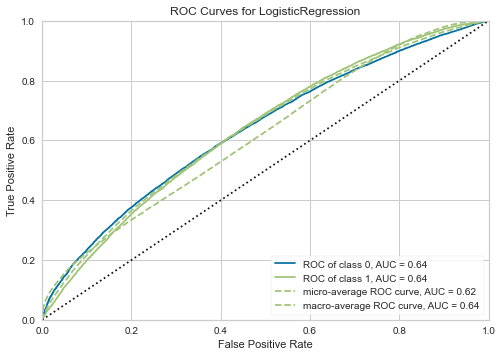

In [96]:
# Tuned ROC

plot_model(tuned_lr, plot = 'auc')

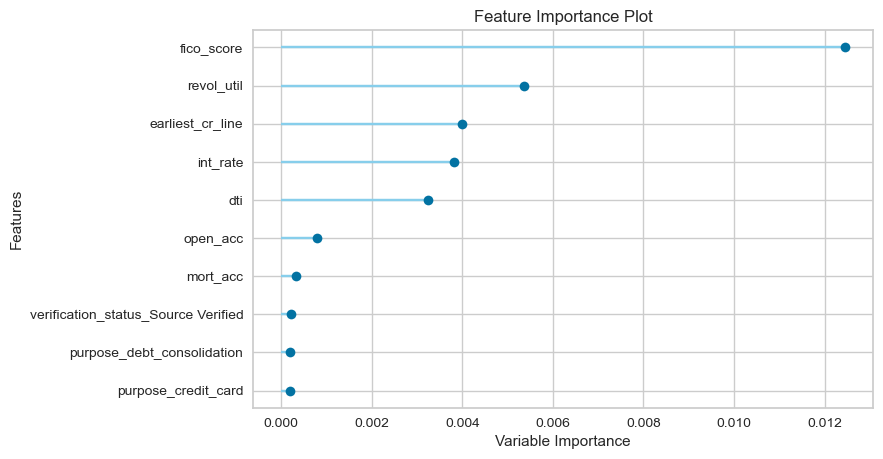

In [97]:
# Feature Importance of tuned model

plot_model(tuned_lr, plot='feature')

In [101]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [102]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
plot_model(adaboost, plot = 'boundary')

## Naive Bayes

In [76]:
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4540,0.6646,0.8168,0.2411,0.3723,0.0954,0.1538
1,0.4471,0.6580,0.8048,0.2368,0.3659,0.0859,0.1390
2,0.4489,0.6601,0.8104,0.2383,0.3683,0.0893,0.1445
3,0.4424,0.6554,0.8112,0.2361,0.3658,0.0848,0.1390
4,0.4487,0.6637,0.8232,0.2402,0.3719,0.0937,0.1532
5,0.4432,0.6478,0.8095,0.2361,0.3656,0.0847,0.1385
6,0.4509,0.6587,0.8238,0.2410,0.3729,0.0956,0.1557
7,0.4581,0.6668,0.8241,0.2437,0.3761,0.1011,0.1626
8,0.4465,0.6593,0.8183,0.2386,0.3695,0.0903,0.1477
9,0.4516,0.6526,0.8063,0.2386,0.3682,0.0898,0.1442


In [77]:
print(nb)

GaussianNB(priors=None, var_smoothing=1e-09)


In [ ]:
#base model ROC

plot_model(nb, plot = 'auc')

In [78]:
tuned_nb = tune_model(nb, optimize='Recall' )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3168,0.6046,0.8876,0.2102,0.3399,0.0286,0.0683
1,0.3198,0.5970,0.8859,0.2107,0.3405,0.0298,0.0703
2,0.3174,0.6081,0.8850,0.2100,0.3395,0.0281,0.0667
3,0.3208,0.6092,0.8905,0.2116,0.3420,0.0319,0.0755
4,0.3165,0.6041,0.8888,0.2103,0.3402,0.0288,0.0690
5,0.3174,0.6060,0.8894,0.2106,0.3406,0.0296,0.0706
6,0.3205,0.6032,0.8818,0.2104,0.3397,0.0288,0.0675
7,0.3248,0.6116,0.8847,0.2119,0.3419,0.0324,0.0750
8,0.3178,0.5980,0.8803,0.2095,0.3385,0.0268,0.0631
9,0.3204,0.6045,0.8853,0.2108,0.3406,0.0300,0.0705


In [79]:
print(tuned_nb)

GaussianNB(priors=None, var_smoothing=2e-07)


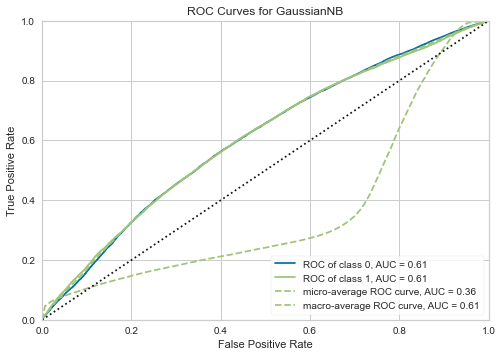

In [113]:
# Tuned ROC

plot_model(tuned_nb, plot = 'auc')

### High Level Model Validation for Light GBM

In [82]:
lightgbm_holdout_pred = predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8025,0.7149,0.0867,0.5258,0.1489,0.0980,0.1507


In [83]:
predictions = predict_model(lightgbm, data = df_dummy)

In [84]:
predictions.sample(10)

,loan_amnt,int_rate,emp_length,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,Label,Score
204408,15000,15,10,0,17,2002,12,1,3255,67,...,0,0,0,0,0,0,0,0,0,0.6601
76057,7200,9,10,0,6,2004,19,0,5073,41,...,0,0,0,0,0,0,0,0,0,0.8853
136143,16000,7,0,1,10,1987,9,0,4375,10,...,0,0,0,0,0,0,0,0,0,0.9387
44972,2000,11,5,0,15,2004,14,1,1627,10,...,0,0,0,0,0,0,0,0,0,0.9146
131593,15000,10,6,0,11,1996,18,0,16515,27,...,0,0,0,0,0,0,0,0,0,0.9059
66775,4000,7,1,0,14,2001,9,1,132,2,...,0,0,0,0,0,0,0,0,0,0.9535
88337,10000,12,3,0,29,2000,7,0,4136,56,...,0,0,0,0,0,0,0,0,0,0.7801
4550,2450,11,6,1,15,1993,12,1,14364,41,...,0,0,0,0,0,0,0,0,0,0.8256
30450,10000,19,10,1,8,1998,7,0,2159,23,...,0,0,0,0,0,0,0,0,0,0.7005
66517,6075,10,9,0,26,2006,9,0,3809,40,...,0,0,0,0,0,0,0,0,0,0.8479


In [85]:
predictions_tuned = predict_model(tuned_lightgbm, data = df_dummy)

In [86]:
predictions_tuned.sample(10)

,loan_amnt,int_rate,emp_length,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,Label,Score
204408,15000,15,10,0,17,2002,12,1,3255,67,...,0,0,0,0,0,0,0,0,1,0.5018
76057,7200,9,10,0,6,2004,19,0,5073,41,...,0,0,0,0,0,0,0,0,0,0.5038
136143,16000,7,0,1,10,1987,9,0,4375,10,...,0,0,0,0,0,0,0,0,0,0.5038
44972,2000,11,5,0,15,2004,14,1,1627,10,...,0,0,0,0,0,0,0,0,0,0.5038
131593,15000,10,6,0,11,1996,18,0,16515,27,...,0,0,0,0,0,0,0,0,0,0.5038
66775,4000,7,1,0,14,2001,9,1,132,2,...,0,0,0,0,0,0,0,0,0,0.5038
88337,10000,12,3,0,29,2000,7,0,4136,56,...,0,0,0,0,0,0,0,0,1,0.5018
4550,2450,11,6,1,15,1993,12,1,14364,41,...,0,0,0,0,0,0,0,0,0,0.5038
30450,10000,19,10,1,8,1998,7,0,2159,23,...,0,0,0,0,0,0,0,0,1,0.5018
66517,6075,10,9,0,26,2006,9,0,3809,40,...,0,0,0,0,0,0,0,0,0,0.5038


## Early Initiative Model Analysis 

* At this point in time with the application of PyCaret with SMOTE were able to improve upon our initial SKLearn Logistic Regression model. 


* With all three benchmark indicators hit .60 across the board this is a positive sign.

Consideration(s):

* Instead of dummying out all our categorical variables, we will map them and see how the models will perform. 


* Class weighting and experimenting with undersampling the majority class as a means of handling the class imbalance.


* Considering an additional metrical called "Net Revenue Function" to better quantify the revenue gain/loss for the business stakeholders.


* All above considerations will be applied both to SKLean models and PyCaret. This is an opportunity to leverage all modeling dependencies to truly create a more robust "best model".


# SWOT Analysis, Minimum Viable Product

## Strengths


Business Analysis: 

* Extensive univariant and bivariant analysis, in terms of understanding the landscape of our current asset. Further, we are also able to hone in on some specific variables that will be addressed and further examined in Phase Two of this initiative.

Modeling:

* Although, at this point only one SkLean model was build, a quick glance using PyCaret helped shed some light on potential weaknesses and threats to this initiative's modeling process. Nonetheless, this is viewed as vital having the ability to see how our current asset responding in the early-mid stage of this initiative. 


Workflow and Process Management:

* As this is the first iteration of the initiative, we were able to create a smooth transition process from notebook to notebook. There are some sections that need to be enhanced and expanded, which will be done post MVP reporting. In terms, of workflow management we have instituted a post-MVP plan of action, subject to priority changes after approval or recommendation from our project management team.


Leveraging External Dependencies (when needed):

* We were able to leverage PyCaret when needed given the MVP deadline. Again, this is not our primary modeling process but will be used a supplement and for enhanced model analysis with respects to the SKLean bespoke models we will continue to build out, tests, and tune. 


* Tableau was used on the onset and will be important in creating the analytics dashboard in Phase II of the initiative. More to come on the business intelligence deployment.



## Weaknesses


Computing Power


* We all recognized that computing and processing power were going to have a great effect in our process management. However, we were able to deploy an additional dependecy/library (PyCaret). Although a great tool, we should not be reliant on one external tool. 


Modeling Process:


* A mentioned above we cannot be reliant on just one modeling library, internal or external. 


* The need to create multiple assets and creating more "model testing" notebooks for better management of model processing and analysis.


* Enhancing and expanding model analysis, which will the be finalized post MVP reporting. 

## Opportunity

Modeling Workforce Management:

* Approaching the MVP deadline has shed some light on much needed modeling workflow management.

1) We will be remapping our modeling operational supply chain to better run multiple concurrent bespoke SKLean models


2) Creating a enhanced and intuitive approach to metrics and model evaluation. We already know how we want to process our post-modeling analysis, but we would like this opportunity to add more metrics that are translatable to our business stakeholders.


Business Intelligence:

* The Deployment of Tableau Dashboards:


1) Storyboarding the customer journey through and highlight key metrics used in the application process.

2) Post model analysis storytelling for business stakeholders.

3) understanding the landscape of applicants whom been rejected via the "rejected_applicant" asset we have also acquired. 

## Threats


Resource Management:

* In Phase II of the initiative, we have listed opportunities above, we needed to also be aware of the time constraints of Phase II. We also recognize there is so much opportunity for enhancements, but we must act cautiously to not miss-manage resources.


Deadline Awareness:

* Again, we would like to take every opportunity to make Phase II a whole a complete project. However, we should also be willing to drop or side-bar certain opportunities to ensure project deliverables are met. This can also viewed as situational awareness and expectation management. 

# P1 (Priority One) for Phase II

* Completing the SkLean modeling process with analysis


* Finalize all Tableau Dashboards for business stakeholders. With user acceptance testing (UAT) of Tableau business intelligence dashboards for key stakeholders


* Have the model ready for pre-deployment, if time willing deployment through a front end user interface


* Finalize project report for business stakeholders. 